In [3]:
import pandas as pd
import os
os.chdir('../../ukbiobank/code/')
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pickle
#import statsmodels.api as sm
import seaborn as sns
from collections import Counter
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
import scipy.stats as stats
from opioidrx_voe.utils import *


In [4]:
os.getcwd()

'/sc/arion/projects/MetaDope/Randy/ehr/ukbiobank/code'

In [5]:
pop = pd.read_csv('../voe_outputs/opioids/controlsLessThan3Opioids/' \
                  'binary_exposure/binary_outcome/controlVarOUD/populations/' \
                  'voe_2010_2013_5yearfollowup_5OpioidsEnrollment_45NCDageExclusion.csv')

In [6]:
pop.shape

(186540, 17)

In [7]:
pop.head()

,Unnamed: 0,eid,yob,mob,sex,gp_records,inpatient_records,age,label,ncd,sickle,hiv,aud,tobacco,sud,opioid_count,MAT
0,0,4955891,1959.0,1.0,Female,378.0,3.0,54.0,0,0,0,0,0,0,0,0.0,0
1,1,2987902,1951.0,9.0,Male,1055.0,73.0,62.0,0,0,0,0,0,0,0,0.0,0
2,2,2250010,1947.0,12.0,Male,378.0,1.0,66.0,0,0,0,0,0,0,0,0.0,0
3,3,3247459,1944.0,11.0,Male,407.0,7.0,69.0,0,0,0,0,0,0,0,0.0,0
4,4,2448170,1948.0,3.0,Male,298.0,NaN,65.0,0,0,0,0,0,0,0,0.0,0


In [8]:
oprx_pop = pop[pop.label==1]

opioid_mrns = oprx_pop.eid
control_mrns = pop[pop.label==0].eid

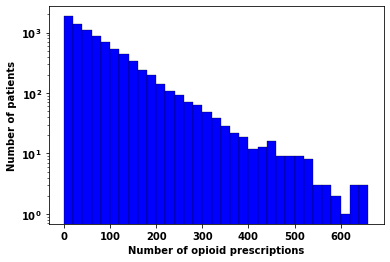

In [63]:
#histogram of opioid prescriptions in OPRx cohort
c,b,_ = plt.hist(oprx_pop.opioid_count, log=True,
                 bins=np.arange(0,680,20), color='blue', edgecolor='black', linewidth=0.3)
plt.xlabel('Number of opioid prescriptions')
plt.ylabel('Number of patients')
plt.savefig('../figures/histogram_OPRx_cohortEnroll5OPRx_enroll2010-2012_NCDAgeExclusion_45.png', dpi=300)

In [10]:
c[2]/oprx_pop.shape[0], c[1]/oprx_pop.shape[0], c[0]/oprx_pop.shape[0]

(0.13035735486168823, 0.16181882939570225, 0.22118010210138905)

In [66]:
def fisher(cases_data, controls_data, factor):
    import scipy.stats as stats
    import sys
    
    ORs = []
    pvalues = []
    cases_with_list = []
    controls_with_list = []
    cases_without_list = []
    controls_without_list = []
    
    #overlapping factors (e.g., dx, rx), Ns of groups
    allfactors = list(set(cases_data[factor]).union(set(controls_data[factor])))
    num_cases = len(set(cases_data.eid))
    num_controls = len(set(controls_data.eid))
    
    #counts of each factor
    cases_rx_counts = cases_data.groupby(factor).groups
    controls_rx_counts = controls_data.groupby(factor).groups
    
    n=0
    for i in allfactors:
        sys.stdout.write('%i out of %i.\r' % (n+1, len(allfactors)))
        sys.stdout.flush()
        
        #number of patients with factor
        if i in list(cases_rx_counts.keys()):
            cases_with = len(set(cases_data.iloc[cases_rx_counts[i]].eid))#cases_data.count(i)
        else: cases_with = 0
        
        if i in list(controls_rx_counts.keys()):
            controls_with = len(set(controls_data.iloc[controls_rx_counts[i]].eid))#controls_data.count(i)
        else: controls_with = 0
        
        cases_without = num_cases - cases_with
        controls_without = num_controls - controls_with
        
        cases_with_list.append(cases_with)
        controls_with_list.append(controls_with)
        cases_without_list.append(cases_without)
        controls_without_list.append(controls_without)
        
        #if any zeros in 2x2 table, add 1 to all cells
        if 0 in [cases_with, cases_without, controls_with, controls_without]:
            oddsratio, pvalue = stats.fisher_exact([[cases_with+1, cases_without+1],
                                                    [controls_with+1, controls_without+1]])
        else:
            oddsratio, pvalue = stats.fisher_exact([[cases_with, cases_without], [controls_with, controls_without]])
        
        ORs.append(oddsratio)
        #bonferroni correction
        pvalues.append(pvalue*len(allfactors))
        
        n+=1
    
    fisher_data = pd.DataFrame()
    fisher_data[factor] = allfactors
    fisher_data['Cases_with'] = cases_with_list
    fisher_data['Cases_w/o'] = cases_without_list
    fisher_data['Cases_percent'] = fisher_data['Cases_with']/num_cases
    fisher_data['Controls_with'] = controls_with_list
    fisher_data['Controls_w/o'] = controls_without_list
    fisher_data['Controls_percent'] = fisher_data['Controls_with']/num_controls
    fisher_data['opi-con_percent'] = fisher_data['Cases_percent'] - fisher_data['Controls_percent']
    fisher_data['Odds_ratio'] = ORs
    fisher_data['p-value (Bonferroni-corrected)'] = pvalues
    
    fisher_data = fisher_data.sort_values(by=['Odds_ratio', 'p-value (Bonferroni-corrected)'],
                                         ascending=[False,True]).reset_index(drop=True)
    
    return fisher_data

## Meds

In [52]:
med = pd.read_parquet('../tidy_data/med.parquet')
readv2_drugs = pd.read_parquet('../tidy_data/read_v2_drugs_lkp.parquet')
blank_drug_name = med[med.drug_name.isna()]
# every single row with a blank drug name has a blank BNF code as well, but they all have ReadV2 codes. Merge with Read2 lookup table
b_merge = blank_drug_name.merge(readv2_drugs[['read_code','term_description']], left_on='read_2', right_on='read_code') 
b_merge.drug_name = b_merge.term_description
b_merge.drop(columns=['read_code', 'term_description'], inplace=True)
med = pd.concat([med[~med.drug_name.isna()], b_merge]).reset_index(drop=True)

(57656140, 7)


In [61]:
def get_drugs(df):
    drugs = []

    for entry in df['drug_name']:
        idx = entry.find(' ')
        drugs.append(entry[:idx])
        
    df['drug'] = drugs
    return df

In [64]:
#Compare medications of controls vs. OPRx, for all meds in patients' entire record

opi_cohort_allmeds = med[med.eid.isin(opioid_mrns)]
opi_cohort_allmeds.issue_date = pd.to_datetime(opi_cohort_allmeds.issue_date)
opi_cohort_allmeds = opi_cohort_allmeds[(opi_cohort_allmeds.issue_date < '01-01-2013')]
opi_cohort_allmeds.reset_index(drop=True, inplace=True)
opi_cohort_allmeds = get_drugs(opi_cohort_allmeds)

con_cohort_allmeds = med[med.eid.isin(control_mrns)]
con_cohort_allmeds.issue_date = pd.to_datetime(con_cohort_allmeds.issue_date)
con_cohort_allmeds = con_cohort_allmeds[(con_cohort_allmeds.issue_date < '01-01-2013')]
con_cohort_allmeds.reset_index(drop=True, inplace=True)
con_cohort_allmeds = get_drugs(con_cohort_allmeds)

/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [67]:
rx_compare = fisher(opi_cohort_allmeds, con_cohort_allmeds, 'drug')

In [68]:
rx_compare.to_csv('../tidy_data/fisher_prescriptions_compare_cohortEnroll5OPRx_enroll2010-2012_NCDAgeExclusion_45.csv')
# rx_compare = pd.read_csv('../tidy_data/fisher_prescriptions_compare_cohortEnroll5OPRx_enroll2014-2016_NCDAgeExclusion_45.csv')

In [69]:
rx_compare.head()

,drug,Cases_with,Cases_w/o,Cases_percent,Controls_with,Controls_w/o,Controls_percent,opi-con_percent,Odds_ratio,p-value (Bonferroni-corrected)
0,TRAMULIEF,23,8400,0.002731,0,150813,0.000000,0.002731,430.845852,3.703391e-26
1,DUROGESIC,141,8282,0.016740,6,150807,0.000040,0.016700,427.911676,2.107957e-167
2,MORPHGESIC,22,8401,0.002612,0,150813,0.000000,0.002612,412.844799,6.737754e-25
3,MAROL,78,8345,0.009260,4,150809,0.000027,0.009234,352.399700,1.874261e-90
4,TAPENTADOL,18,8405,0.002137,0,150813,0.000000,0.002137,340.883417,7.235394e-20


In [77]:
opioid_rx = pd.read_parquet('../tidy_data/opioid_med.parquet')
print(opioid_rx.shape)
blank_drug_name = opioid_rx[opioid_rx.drug_name.isna()]
# every single row with a blank drug name has a blank BNF code as well, but they all have ReadV2 codes. Merge with Read2 lookup table
b_merge = blank_drug_name.merge(readv2_drugs[['read_code','term_description']], left_on='read_2', right_on='read_code') 
b_merge.drug_name = b_merge.term_description
b_merge.drop(columns=['read_code', 'term_description'], inplace=True)
opioid_rx = pd.concat([opioid_rx[~opioid_rx.drug_name.isna()], b_merge]).reset_index(drop=True)
print(opioid_rx.shape)
opioid_rx = get_drugs(opioid_rx)

(1136618, 7)
(1136618, 7)


(1213, 10)
(1155, 10)
(189, 10)


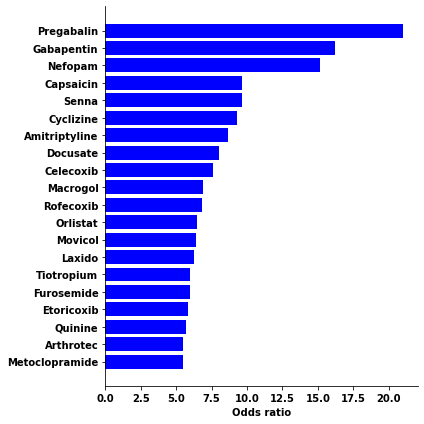

In [79]:
fig, ax = plt.subplots(figsize=(6,6))

variable = 'Odds_ratio'
rx_compare_sig = rx_compare[rx_compare['p-value (Bonferroni-corrected)']<0.05].sort_values(variable, ascending=False)
# rx_compare_sig = rx_compare_sig[~rx_compare_sig.PHARMACEUTICAL_CLASS.str.contains('OPIOID')]
print(rx_compare_sig.shape)
rx_compare_sig = rx_compare_sig[~rx_compare_sig.drug.isin(opioid_rx.drug)]
print(rx_compare_sig.shape)
rx_compare_sig = rx_compare_sig[(rx_compare_sig.Cases_percent>0.05) | 
                               ((rx_compare_sig.Controls_percent>0.05))]
print(rx_compare_sig.shape)
#if there are any drugs overrepresented in the controls, show the top and bottom 10
# if min(rx_compare_sig[variable])<1:
#     data = pd.concat([rx_compare_sig[:10], rx_compare_sig[-10:]])
# #if not, just show the top 20
# else:
data = rx_compare_sig[:20]

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax.barh(np.arange(data.shape[0]), data[variable],  align='center', color='blue')
ax.set_yticks(np.arange(data.shape[0]), labels=data.drug.str.title())
# ax.set_yticks(())

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Odds ratio')
plt.tight_layout()
plt.savefig('../figures/rx_fisherTest_oddsratio_bargraph_OPRx_cohortEnroll5OPRx_enroll2010-2012_NCDAgeExclusion_45.png', dpi=300)

## Diagnoses

In [80]:
dx = pd.read_parquet('../tidy_data/icd_data_all_dx.parquet')


In [81]:
dx.head()

,eid,event_dt,icd_code,DESCRIPTION,icd_type,source,AGE_AT_ENCOUNTER
0,1371460,1990-06-21,3000,ANXIETY STATES,9,GP,36.139630
1,1935764,2015-11-06,V254,SURVEILLANCE OF PREVIOUSLY PRESCRIBED CONTRACE...,9,GP,51.761807
2,1748537,2014-09-16,3027,FRIGIDITY AND IMPOTENCE,9,GP,45.544148
3,5119574,2010-04-24,M814/-M838/,None,9,GP,68.813142
4,5854769,2000-02-11,311,"DEPRESSIVE DISORDER, NOT ELSEWHERE CLASSIFIED",9,GP,56.112252


In [82]:
opi_cohort_dx = dx[dx.eid.isin(opioid_mrns)]
opi_cohort_dx['event_dt'] = pd.to_datetime(opi_cohort_dx['event_dt'])
opi_cohort_dx = opi_cohort_dx[(opi_cohort_dx.event_dt<'01-01-2013')]
opi_cohort_dx.reset_index(drop=True, inplace=True)


con_cohort_dx = dx[dx.eid.isin(control_mrns)]
con_cohort_dx['event_dt'] = pd.to_datetime(con_cohort_dx['event_dt'])
con_cohort_dx = con_cohort_dx[(con_cohort_dx.event_dt<'01-01-2013')]
con_cohort_dx.reset_index(drop=True, inplace=True)

/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [83]:
dx_compare = fisher(opi_cohort_dx, con_cohort_dx, 'DESCRIPTION')

In [84]:
dx_compare.to_csv('../tidy_data/fisher_diagnoses_compare_cohortEnroll5OPRx_enroll2010-2012_NCDAgeExclusion_45.csv')
# dx_compare = pd.read_csv('../tidy_data/fisher_diagnoses_compare_cohortEnroll5OPRx_enroll2014-2016_NCDAgeExclusion_45.csv')

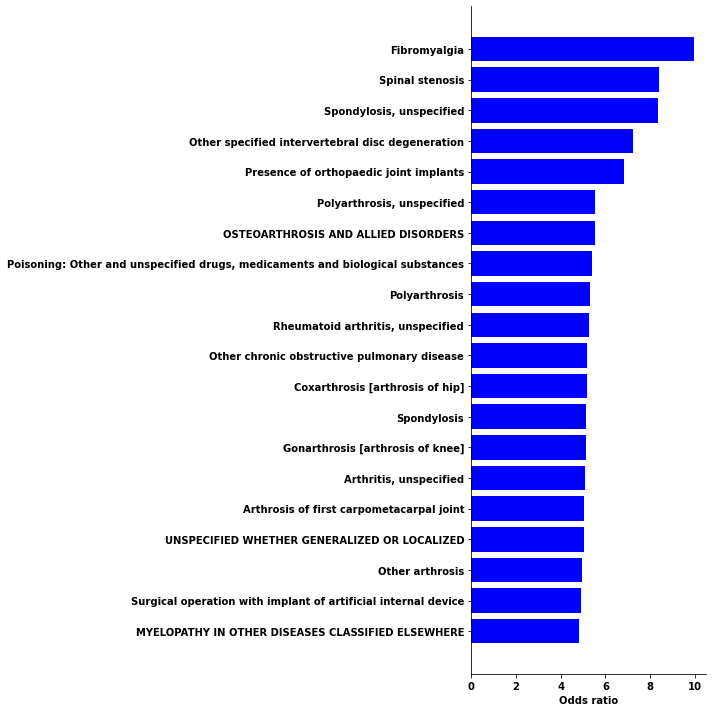

In [89]:
fig, ax = plt.subplots(figsize=(10,10))

variable = 'Odds_ratio'
dx_compare_sig = dx_compare[dx_compare['p-value (Bonferroni-corrected)']<0.05].sort_values(variable, ascending=False)
dx_compare_sig = dx_compare_sig[~dx_compare_sig.DESCRIPTION.str.contains('|'.join(['Opioid','opioid']))]
dx_compare_sig = dx_compare_sig[(dx_compare_sig.Cases_percent>0.05) | 
                               ((dx_compare_sig.Controls_percent>0.05))]

#if there are any drugs overrepresented in the controls, show the top and bottom 10
# if min(rx_compare_sig[variable])<1:
#     data = pd.concat([dx_compare_sig[:10], dx_compare_sig[-10:]])
# #if not, just show the top 20
# else:
data = dx_compare_sig[:20]
    
    
# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax.barh(np.arange(data.shape[0]), data[variable],  align='center', color='blue')

# yticks = data.LABEL.tolist()
# yticks[4] = 'Alcohol dependence, continuous'
# yticks[5] = 'Alcohol dependence, unspecified'
# yticks[6] = 'Drug abuse, unspecified'
# yticks[10] = 'Open wound of finger(s), no complications'
# yticks[11] = 'Abnormal results of cardiovascular function study'
# yticks[12] = 'Accidents from cutting/piercing instruments'
# yticks[14] = 'Benign hypertensive heart disease w/o heart failure'
# yticks[16] = 'Routine general medical examination'
# yticks[17] = 'Benign neoplasm of connective tissue of upper limb'
# yticks[19] = 'Malignant hypertensive heart disease w/o heart failure'

ax.set_yticks(np.arange(data.shape[0]), labels=data.DESCRIPTION)#yticks)
# ax.set_yticks(())

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Odds ratio')
plt.tight_layout()
plt.savefig('../figures/dx_fisherTest_oddsratio_OPRx_cohortEnroll5OPRx_enroll2014-2016_NCDAgeExclusion_45.png', dpi=300)